In [1]:
# import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
import os

from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [2]:
# Reading and consultation

df = pd.read_csv(r'./SEER Breast Cancer Dataset .csv', encoding='ascii')
df.head(3)

,Age,Race,Marital Status,Unnamed: 3,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,43,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N3,IIIC,Moderately differentiated; Grade II,Regional,40,Positive,Positive,19,11,1,Alive
1,47,"Other (American Indian/AK Native, Asian/Pacifi...",Married (including common law),NaN,T2,N2,IIIA,Moderately differentiated; Grade II,Regional,45,Positive,Positive,25,9,2,Alive
2,67,White,Married (including common law),NaN,T2,N1,IIB,Poorly differentiated; Grade III,Regional,25,Positive,Positive,4,1,2,Dead


In [3]:
# Drop unvalide column 'Unnamed'
df = df.drop(columns=['Unnamed: 3'])
df.columns


Index(['Age', 'Race ', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage',
       'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')

In [4]:
# Nombre de caractéristiques (colonnes) et d'échantillons (lignes)
num_features = df.shape[1]
num_samples = df.shape[0]
print("\nNombre de caractéristiques (colonnes) :", num_features)
print("Nombre d'échantillons (lignes) :", num_samples)


Nombre de caractéristiques (colonnes) : 15
Nombre d'échantillons (lignes) : 7108


In [5]:
# Distribution des statuts (Alive vs Dead)
status_distribution = df['Status'].value_counts()
print("\nDistribution des statuts :")
print(status_distribution)


Distribution des statuts :
Status
Alive     4472
Dead      2634
Status       1
Name: count, dtype: int64


In [6]:
# Spliting the Data into training Set qnd test set
# Conserving data 
dfs = df
# Nettoyage des noms des colonnes
df.columns = df.columns.str.strip()

# Get The target Status ( "Dead or Alive")
df['Status_encoded'] = df['Status'].map({'Alive': 0, 'Dead': 1})
Y = df['Status_encoded']

# Choosing features/inputs
dfs = dfs.drop(columns=['Status'])
X = df[['Age', '6th Stage', 'Tumor Size', 'Grade', 'T Stage', 'N Stage','Regional Node Examined',
        'Reginol Node Positive','Survival Months']]
# Train_Set and Test_Set
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8,random_state=42)

print("Inputs :  \n", X_train.columns)
print("Target :  \n", Y_train)
print(Y_train.isnull().sum())
print(Y_test.isnull().sum())

# Supprimer les lignes correspondantes aux NaN dans Y_train
X_train = X_train[~Y_train.isnull()]
Y_train = Y_train.dropna()
# Remplacer les NaN dans Y_train par la classe majoritaire
Y_train = Y_train.fillna(Y_train.mode()[0])
print(Y_train.isnull().sum())  # Devrait afficher 0
print("this is : ",X_train.columns)  # Should show (num_samples, 9)



Inputs :  
 Index(['Age', '6th Stage', 'Tumor Size', 'Grade', 'T Stage', 'N Stage',
       'Regional Node Examined', 'Reginol Node Positive', 'Survival Months'],
      dtype='object')
Target :  
 6339    1.0
6963    0.0
1555    0.0
6421    1.0
3190    1.0
       ... 
3772    0.0
5191    1.0
5226    0.0
5390    0.0
860     1.0
Name: Status_encoded, Length: 1421, dtype: float64
0
2
0
this is :  Index(['Age', '6th Stage', 'Tumor Size', 'Grade', 'T Stage', 'N Stage',
       'Regional Node Examined', 'Reginol Node Positive', 'Survival Months'],
      dtype='object')


In [7]:

# Fitting Models and getting the best one
def train_and_evaluate_models(X_Train, X_Test, Y_Train, Y_Test):
   

    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'SVM': SVC(random_state=42)
    }

    results = {}
    for model_name, model in models.items():
       
        # Train the model
        model.fit(X_Train, Y_Train)
        
        # Make predictions
        y_pred = model.predict(X_Test)
        
        # Evaluate model
        accuracy = accuracy_score(Y_Test, y_pred)
        cm = confusion_matrix(Y_Test, y_pred)
        cr = classification_report(Y_Test, y_pred)
        results[model_name] = {
            'model': model,
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'classification_report': cr
        }

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}\nAccuracy: {accuracy:.4f}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        print(f"\nClassification Report for {model_name}:")
        print(cr)

    return results



# Function to find the best model
def get_best_model(results):
    best_accuracy = 0
    best_model_name = None
    
    for name, result in results.items():
        if result['accuracy'] > best_accuracy:
            best_accuracy = result['accuracy']
            best_model_name = name
    
    return best_model_name, best_accuracy


In [8]:
def save_model_components(model, categorical_columns, best_model_name):
    # Create a directory for saving if it doesn't exist
    if not os.path.exists('model'):
        os.makedirs('model')
    
    # Save the entire pipeline (preprocessor + model)
    joblib.dump(model, 'model/best_model.pkl')

    # Save categorical columns list
    joblib.dump(categorical_columns, 'model/categorical_columns.pkl')
    
    # Save model name
    with open('model/model_info.txt', 'w') as f:
        f.write(f"Best Model: {best_model_name}")
    
    print(f"Pipeline and model metadata saved successfully. Best model: {best_model_name}")


In [9]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def process(df):
    # Define categorical columns
    categorical_columns = ['6th Stage', 'T Stage', 'N Stage', 'Grade']
    
    # Create copy of dataframe
    df_model = df.copy()

    # Initialize and fit label encoders for categorical columns
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col])
        label_encoders[col] = le

    # Handle the target variable ("Status") as a binary encoded value (0 for Alive, 1 for Dead)
    df_model['Status_encoded'] = df_model['Status'].map({'Alive': 0, 'Dead': 1})
    y = df_model['Status_encoded']

    # Choosing features/inputs (excluding 'Status')
    numeric_columns = ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']
    X = df_model[numeric_columns + categorical_columns]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Handle missing values in the target variable
    X_train = X_train[~y_train.isnull()]
    y_train = y_train.dropna()

    # Replace NaN in y_train with the most frequent class (mode)
    y_train = y_train.fillna(y_train.mode()[0])

    # Optionally, save the feature order to a file
    joblib.dump(X.columns.tolist(), "model/feature_order.pkl")

    # Save the label encoders to a file
    joblib.dump(label_encoders, "model/label_encoders.pkl")

    # Print a success message
    print("Label encoders saved successfully to 'model/label_encoders.pkl'.")

    # Train and evaluate models (assume you have a `train_and_evaluate_models` function)
    results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

    # Get the best model
    best_model_name, best_accuracy = get_best_model(results)
    print(f"\nBest Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")

    # Save the best model and its components
    best_model = results[best_model_name]['model']
    save_model_components(best_model, categorical_columns, best_model_name)
    print(f"Model and components saved successfully. Best model: {best_model_name}")


Label encoders saved successfully to 'model/label_encoders.pkl'.


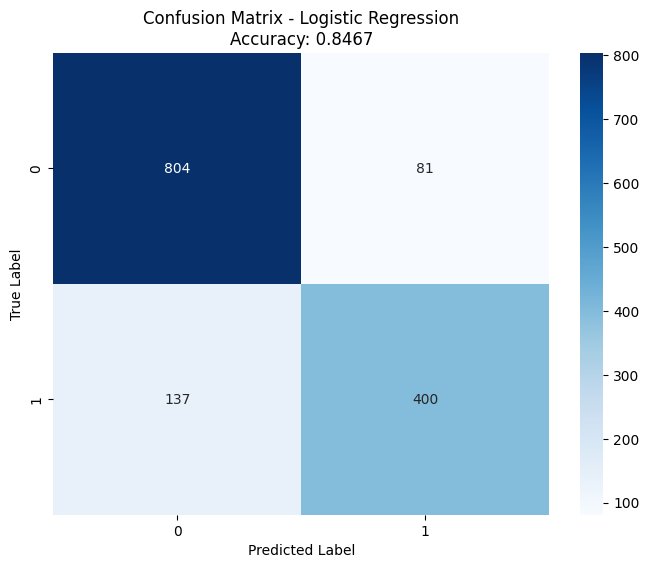


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88       885
         1.0       0.83      0.74      0.79       537

    accuracy                           0.85      1422
   macro avg       0.84      0.83      0.83      1422
weighted avg       0.85      0.85      0.84      1422



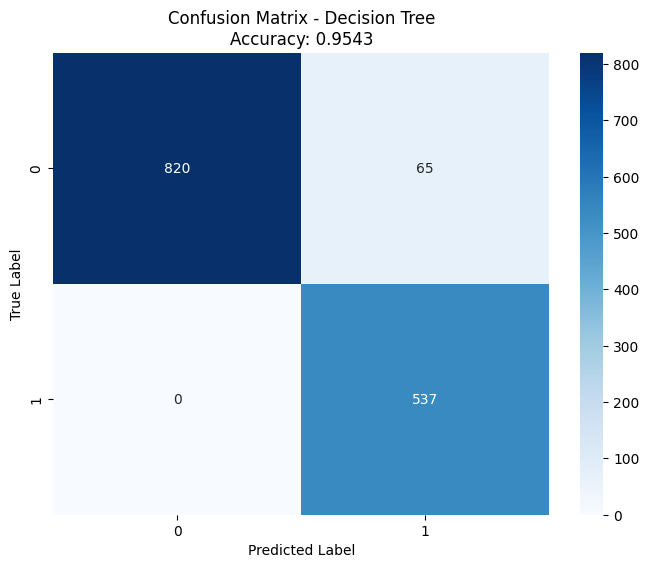


Classification Report for Decision Tree:
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96       885
         1.0       0.89      1.00      0.94       537

    accuracy                           0.95      1422
   macro avg       0.95      0.96      0.95      1422
weighted avg       0.96      0.95      0.95      1422



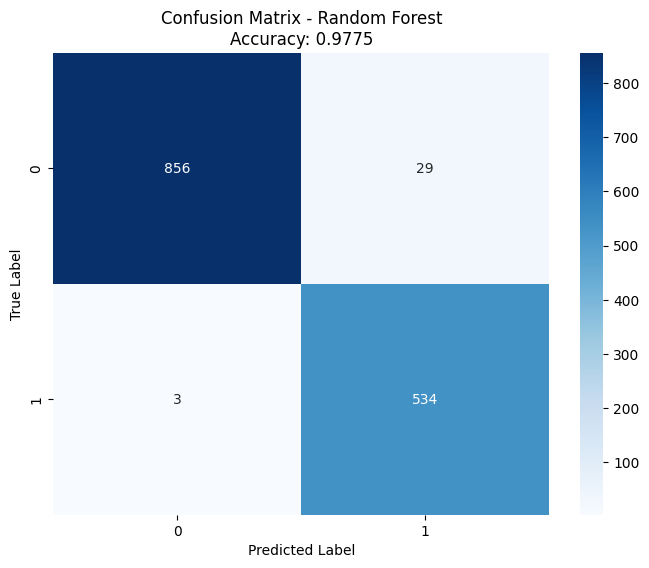


Classification Report for Random Forest:
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98       885
         1.0       0.95      0.99      0.97       537

    accuracy                           0.98      1422
   macro avg       0.97      0.98      0.98      1422
weighted avg       0.98      0.98      0.98      1422



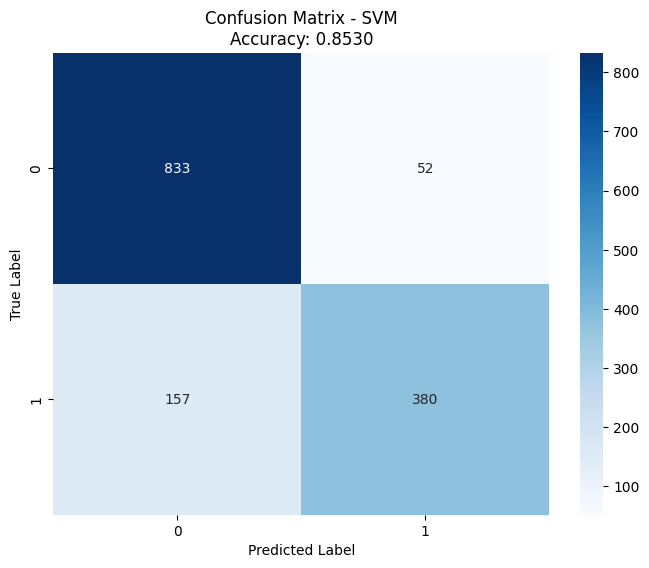


Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89       885
         1.0       0.88      0.71      0.78       537

    accuracy                           0.85      1422
   macro avg       0.86      0.82      0.84      1422
weighted avg       0.86      0.85      0.85      1422


Best Model: Random Forest with Accuracy: 0.9775
Pipeline and model metadata saved successfully. Best model: Random Forest
Model and components saved successfully. Best model: Random Forest


In [10]:
process(df)

In [11]:
import pandas as pd
import joblib

# Charger le modèle et les colonnes d'entraînement
best_model = joblib.load("model/best_model.pkl")
trained_columns = joblib.load("model/feature_order.pkl")
label_encoders = joblib.load("model/label_encoders.pkl")

# Charger les données de test
input_file = "./cleaned_test_dataset.csv"
data = pd.read_csv(input_file)

# Nettoyer les noms de colonnes
data.columns = data.columns.str.strip()

# Appliquer les encodages aux colonnes catégoriques
categorical_columns = ['6th Stage', 'N Stage', 'T Stage', 'Grade']
for col in categorical_columns:
    if col in data.columns:
        data[col] = label_encoders[col].transform(data[col])

# Convertir les colonnes numériques
numeric_columns = ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Ajouter les colonnes manquantes avec des valeurs par défaut
missing_columns = [col for col in trained_columns if col not in data.columns]
for col in missing_columns:
    data[col] = 0

# Réorganiser les colonnes dans l'ordre attendu par le modèle
data = data[trained_columns]

# Vérifier que les dimensions correspondent
if data.shape[1] != len(trained_columns):
    raise ValueError(f"Le nombre de colonnes ({data.shape[1]}) ne correspond pas au nombre attendu ({len(trained_columns)}).")

# Faire les prédictions
predictions = best_model.predict(data)
prediction_proba = best_model.predict_proba(data)

# Ajouter les prédictions aux données
data['Prediction'] = predictions
data['Probability'] = prediction_proba[:, 1]

# Sauvegarder les résultats
output_file = "predictions_output.csv"
data.to_csv(output_file, index=False)
print(f"Prédictions sauvegardées dans : {output_file}")


Prédictions sauvegardées dans : predictions_output.csv
